## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Черепнина Мария Сергеевна

In [26]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
from IPython.display import clear_output
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [15]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [16]:
images_train, labels_train = next(iter(train_loader))

In [17]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

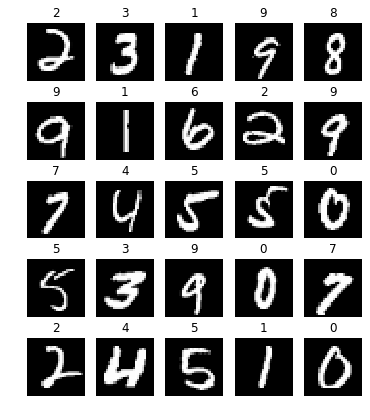

In [18]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print ('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print ('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [8]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): ReLU()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): ReLU()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): ReLU()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [9]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9813615083694458
forward 1.0310897827148438
forward 1.0142043828964233
forward 0.9944884181022644
forward 0.928407609462738
forward 0.9115141034126282
forward 0.86093670129776
forward 0.8569043278694153
forward 0.8233437538146973
forward 0.8449583649635315
forward 0.8583260774612427
forward 0.8457435369491577
backward 0.2901358902454376
backward 0.24620380997657776
backward 0.20376133918762207
backward 0.18000255525112152
backward 0.15655967593193054
backward 0.1390387862920761
backward 0.12402895838022232
backward 0.11214666068553925
backward 0.09998182952404022
backward 0.09076806157827377
backward 0.07990343123674393
backward 0.06645064800977707


/home/maria/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [12]:
# ReLU + He
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9813615083694458
forward 1.0317589044570923
forward 1.0168604850769043
forward 1.0299900770187378
forward 1.0463156700134277
forward 1.011839747428894
forward 1.028729796409607
forward 1.088147521018982
forward 1.0477699041366577
forward 0.9692335724830627
forward 0.9740687608718872
forward 0.9664243459701538
backward 0.13030500710010529
backward 0.10112141072750092
backward 0.0928146243095398
backward 0.08451618999242783
backward 0.08043751865625381
backward 0.07882065325975418
backward 0.07309623062610626
backward 0.06636149436235428
backward 0.06522186845541
backward 0.0586887001991272
backward 0.05551210418343544
backward 0.050970032811164856


In [13]:
# Tanh + He
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9813615083694458
forward 0.7573811411857605
forward 0.6151880025863647
forward 0.6195283532142639
forward 0.631337583065033
forward 0.6573521494865417
forward 0.6833194494247437
forward 0.6688786745071411
forward 0.6811237931251526
forward 0.6453576683998108
forward 0.6467225551605225
forward 0.6037557721138
backward 0.19880925118923187
backward 0.16937078535556793
backward 0.15927006304264069
backward 0.13628621399402618
backward 0.12157229334115982
backward 0.10562140494585037
backward 0.09728565067052841
backward 0.09180418401956558
backward 0.09078000485897064
backward 0.07618864625692368
backward 0.0664488896727562
backward 0.048107296228408813


In [11]:
# ReLU + Xavier
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./(784 + 500))))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./(500 + 500))))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./(500 + 10))))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9813615083694458
forward 0.6466431617736816
forward 0.4763685166835785
forward 0.33555111289024353
forward 0.23247912526130676
forward 0.16570618748664856
forward 0.11266294121742249
forward 0.08553186804056168
forward 0.05527729168534279
forward 0.03698435053229332
forward 0.026660142466425896
forward 0.01856018602848053
backward 0.030764954164624214
backward 0.004353039897978306
backward 0.0032775530125945807
backward 0.0024236540775746107
backward 0.0017139858100563288
backward 0.001160701154731214
backward 0.0008416278287768364
backward 0.0005845659179612994
backward 0.00042544552707113326
backward 0.0003015416441485286
backward 0.00021377913071773946
backward 0.00015094311675056815


In [10]:
# Tanh + Xavier
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./(784 + 500))))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./(500 + 500))))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./(500 + 10))))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9813615083694458
forward 0.6458089351654053
forward 0.5001532435417175
forward 0.4194175601005554
forward 0.3633563816547394
forward 0.3268231451511383
forward 0.3002658784389496
forward 0.27941659092903137
forward 0.25774452090263367
forward 0.24192024767398834
forward 0.22751575708389282
forward 0.21958068013191223
backward 0.0336652472615242
backward 0.00605170289054513
backward 0.005938070360571146
backward 0.005800129845738411
backward 0.00529047567397356
backward 0.005069861188530922
backward 0.004683800041675568
backward 0.004374942742288113
backward 0.004008476622402668
backward 0.0036374409683048725
backward 0.0029293610714375973
backward 0.0020766027737408876


<i> 1.4 Сделайте выводы по первой части </i>

Для **ReLu** лучше подходит инициализация **He**, для **Tanh** - **Xavier** (медленне затухают значения)

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [27]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 9... (Train/Test) NLL: 0.025/0.074	Accuracy: 0.992/0.980


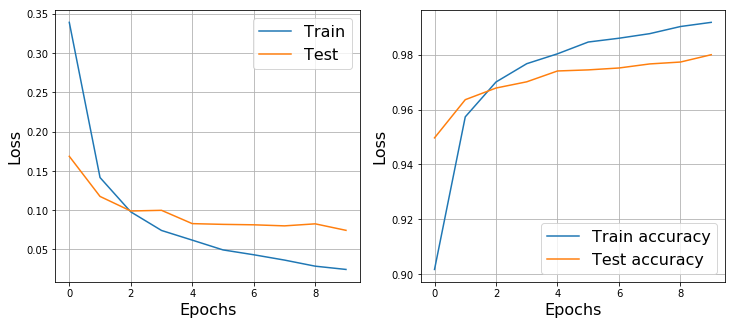

In [28]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())


train(network, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.197/0.219	Accuracy: 0.942/0.938


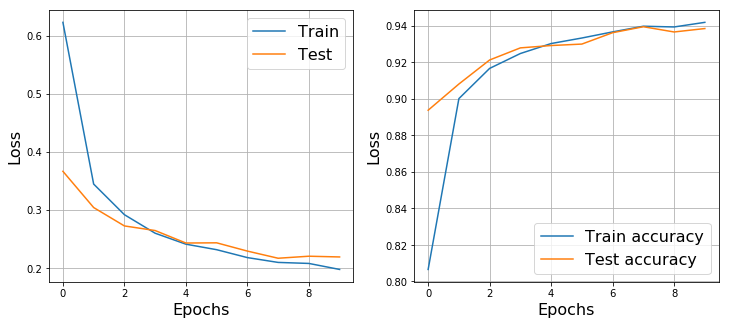

In [30]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

In [31]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

Epoch 9... (Train/Test) NLL: 0.122/0.136	Accuracy: 0.962/0.959


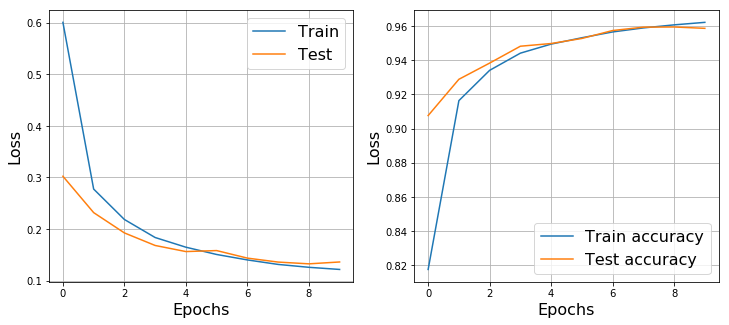

In [32]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 9... (Train/Test) NLL: 0.121/0.157	Accuracy: 0.964/0.956


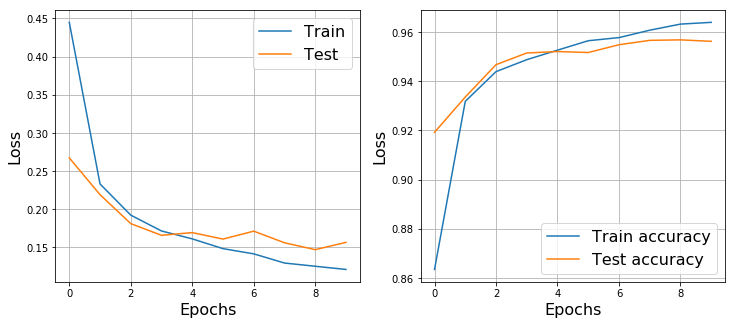

In [37]:
##### YOUR CODE HERE #####

# 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.108/0.133	Accuracy: 0.967/0.961


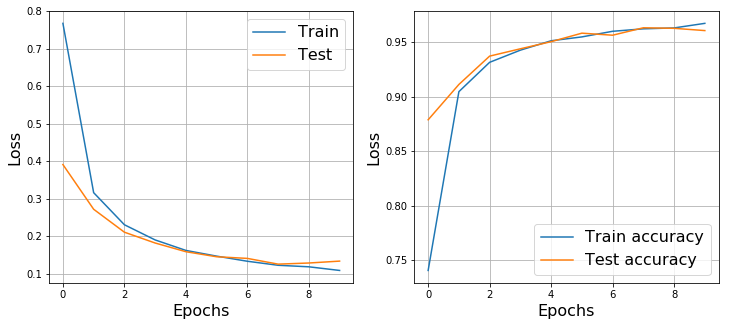

In [38]:
# 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев 
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

<i> 2.3 Сделайте выводы по третьей части </i>

Качество с **DropConnect** незначительно лучше, чем с **Dropout**

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [39]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=1).view(-1, 1)) / x.std(dim=1).view(-1, 1)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.013/0.084	Accuracy: 0.996/0.978


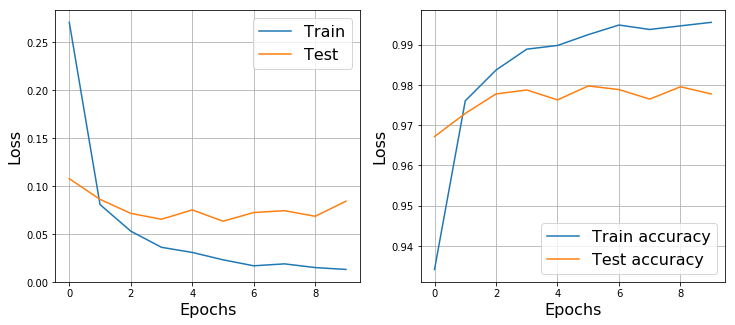

In [42]:
##### YOUR CODE HERE #####

# 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.020/0.060	Accuracy: 0.994/0.982


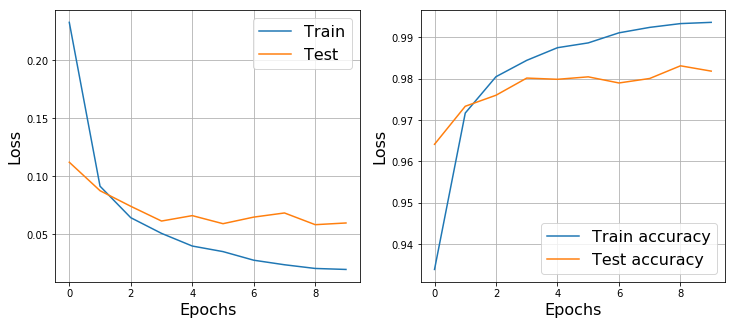

In [40]:
# 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

**Layer normalization** дает чуть лучший результат. Вероятно, это происходит из-за того, что при работе с батчем сеть настраивается по среднему ~~по больнице~~ по разным объектам (в нашем случае разным изображением цифр), при **Layer normalization** этой проблемы нет

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: